In [3]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

In [25]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('ggplot')

In [ ]:
driver.get('https://www.x.com/buildings?status=completed&material=all&function=all&location=world&year=2025')

In [ ]:
options=[e.text for e in driver.find_elements(By.CSS_SELECTOR,'select[name="x"] option') if e.text.startswith(' ')==False and e.text!='the World']

In [ ]:
import requests
response = requests.get("https://restcountries.com/v3.1/all")
if response.status_code == 200:
    countries = [country['name']['common'] for country in response.json()]

In [ ]:
for option in options:
    if option not in countries:
        print(option)

In [ ]:
more_countries=['Türkiye','Czech Republic']
for country in more_countries:
    countries.append(country)

In [ ]:
years=sorted([i for i in range(1890,2026) if i%10==0 or i==2025],reverse=True)
years

In [ ]:
def return_links():
    rows=WebDriverWait(driver,10).until(expected_conditions.visibility_of_all_elements_located((By.CSS_SELECTOR,'table[id="x"] tbody tr[role="x"]')))
    links=[]
    for row in rows:
        try:
            link=row.find_element(By.CSS_SELECTOR,'p[class="x"] a').get_attribute('href')
        except:
            link=None
        
        links.append(link)

    return links

In [ ]:
hrefs=['-'.join([t.lower().strip() for t in country.split(' ')]) for country in countries]


all_tables=pd.DataFrame()
for i, href in enumerate(hrefs,start=1):
    country_url=f'https://www.x.com/buildings?status=completed&material=all&function=all&location=country-{href}&year=2025'
    driver.get(country_url)
    time.sleep(2)

    html=driver.page_source

    try:
        table=[i for i in pd.read_html(html) if i.columns[0]=='Rank' and i.columns[1]=='Name'][0]
        if len(table)<100:
            try:
                links=return_links()
                table['Links']=links
                table['Country']=href
                
            except:
                print(f'length does not match - {country_url}')

            all_tables=pd.concat([all_tables,table],ignore_index=True)
            continue

    except:
        continue

    for year in years:
        country_url=f'https://www.x.com/buildings?status=completed&material=all&function=all&location=country-{href}&year={year}'
        driver.get(country_url)
        time.sleep(2)
        html=driver.page_source

        try:
            table=[i for i in pd.read_html(html) if i.columns[0]=='Rank' and i.columns[1]=='Name'][0]
            if len(table)<100:
                try:
                    links=return_links()
                    table['Links']=links
                    table['Country']=href
                except:
                    print(f'length does not match - {country_url}')

                all_tables=pd.concat([all_tables,table],ignore_index=True)
                break
            try:
                links=return_links()
                table['Links']=links
                table['Country']=href
            except:
                print(f'length does not match - {country_url}')

            all_tables=pd.concat([all_tables,table],ignore_index=True)

            print(f'{i}/{len(hrefs)}',href, year, end='\r')
            
        except:
            continue
    


In [3]:
driver.quit()

In [4]:
#all_tables.to_csv('worlds_tallest_buildings.csv',index=False)

In [ ]:
df=pd.read_csv('worlds_tallest_buildings.csv')

In [ ]:
df.columns=['Rank','Name','City','Status','Completion Year','Height','Floors','Material Used','Function','Link', 'Country']

In [ ]:
df=df.drop(columns='Status')

In [ ]:
df=df.drop_duplicates(subset=df.columns[1:])

In [ ]:
df=df.sort_values(['Link','Function']).drop_duplicates(subset='Link',keep='first')

In [ ]:
df=df.drop(columns='Rank')

In [ ]:
df['Height']=df['Height'].apply(lambda x:x.split('m')[0].strip() if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Height':'Height (m)'})

In [ ]:
df['Floors']=df['Floors'].apply(pd.to_numeric)

In [ ]:
df=df.sort_values('Height (m)',ascending=False).reset_index(drop=True)

In [ ]:
df.select_dtypes(object).nunique()

df.isna().mean()

In [ ]:
df['Country']=df['Country'].apply(lambda x:' '.join([i.title() for i in x.split('-')]))

In [ ]:
addresses=[]
for i, link in enumerate(df['Link'],start=1):
    try:
        html=requests.get(link,headers).content
        soup=BeautifulSoup(html)
        address=[i for i in soup.select('div[class="flex flex-wrap"] div[class="flex row w-full px-4"]') if 'Address' in i.text][0].text.replace('\n','')
    except:
        address=None

    addresses.append(address)

    print(f'{i}/{len(df)}',end='\r')

df['Address']=addresses

In [ ]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="YourAppName-YourEmail@example.com")

country_city_list = df.apply(lambda x: f"{x['Country']}, {x['City']}", axis=1).unique().tolist()

#coordinates = {}
coordinates=pickle.load(open('coordinates.pickle','rb'))

for i, country_city in enumerate(country_city_list, start=1): 
    if country_city in coordinates:
        continue
    location = geolocator.geocode(country_city)
    if location:
        lat, lon = location.latitude, location.longitude
    else:
        lat, lon = None, None
    
    coordinates[country_city]={'Lat':lat,'Lon':lon}
    
    print(f"{i}/{len(country_city_list)} -> {country_city} -> Lat: {lat}, Lon: {lon}", flush=True,end='\r')

    time.sleep(1)  

df['City Lon'] = df.apply(lambda x: f"{x['Country']}, {x['City']}", axis=1).map(coordinates).apply(lambda x:x['Lon'])
df['City Lat'] = df.apply(lambda x: f"{x['Country']}, {x['City']}", axis=1).map(coordinates).apply(lambda x:x['Lat'])


In [ ]:
df=df[['Name','City','Country','Completion Year','Height (m)', 'Floors', 'Material Used', 'Function','City Lat', 'City Lon']]

In [5]:
#df.to_csv('worlds_tallest_buildings (cleaned).csv',index=False)

In [4]:
df=pd.read_csv("worlds_tallest_buildings (cleaned).csv")

In [7]:
df

,Name,City,Country,Completion Year,Height (m),Floors,Material Used,Function,City Lat,City Lon
0,Burj Khalifa,Dubai,United Arab Emirates,2010.0,828,163.0,Steel Over Concrete,Office / Residential / Hotel,25.074282,55.188539
1,Merdeka 118,Kuala Lumpur,Malaysia,2023.0,679,118.0,Concrete-Steel Composite,Hotel / Serviced Apartments / Office,3.152659,101.702220
2,Shanghai Tower,Shanghai,China,2015.0,632,128.0,Concrete-Steel Composite,Hotel / Office,31.231271,121.470015
3,Makkah Royal Clock Tower,Mecca,Saudi Arabia,2012.0,601,120.0,Steel Over Concrete,Serviced Apartments / Hotel / Retail,21.420847,39.826869
4,Ping An Finance Center,Shenzhen,China,2017.0,599,115.0,Concrete-Steel Composite,Office,22.544574,114.054543
...,...,...,...,...,...,...,...,...,...,...
8160,Liechtensteinische Post,Vaduz,Liechtenstein,NaN,24,6.0,NaN,Office,47.139286,9.522796
8161,Pentagon II,As,Norway,2013.0,24,8.0,All-Timber,Residential,59.679281,10.774164
8162,United States Capitol,Washington D.C.,United States,1815.0,24,3.0,All-Masonry,Government,38.895037,-77.036543
8163,"Frederiks Plads, South Building",Aarhus,Denmark,2017.0,24,7.0,NaN,Residential,56.149628,10.213405


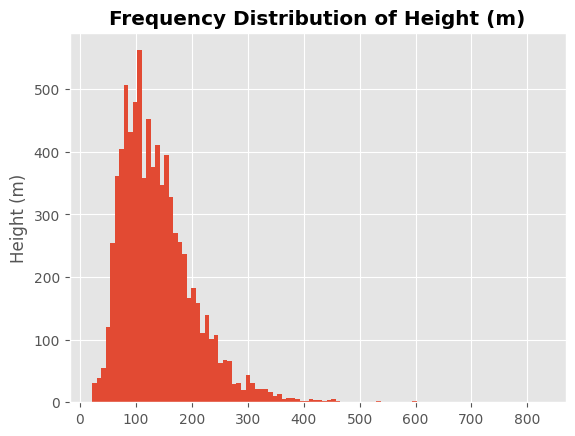

In [8]:
df['Height (m)'].hist(bins=100)
plt.title('Frequency Distribution of Height (m)', fontweight='bold')
plt.ylabel('Height (m)')
plt.show()

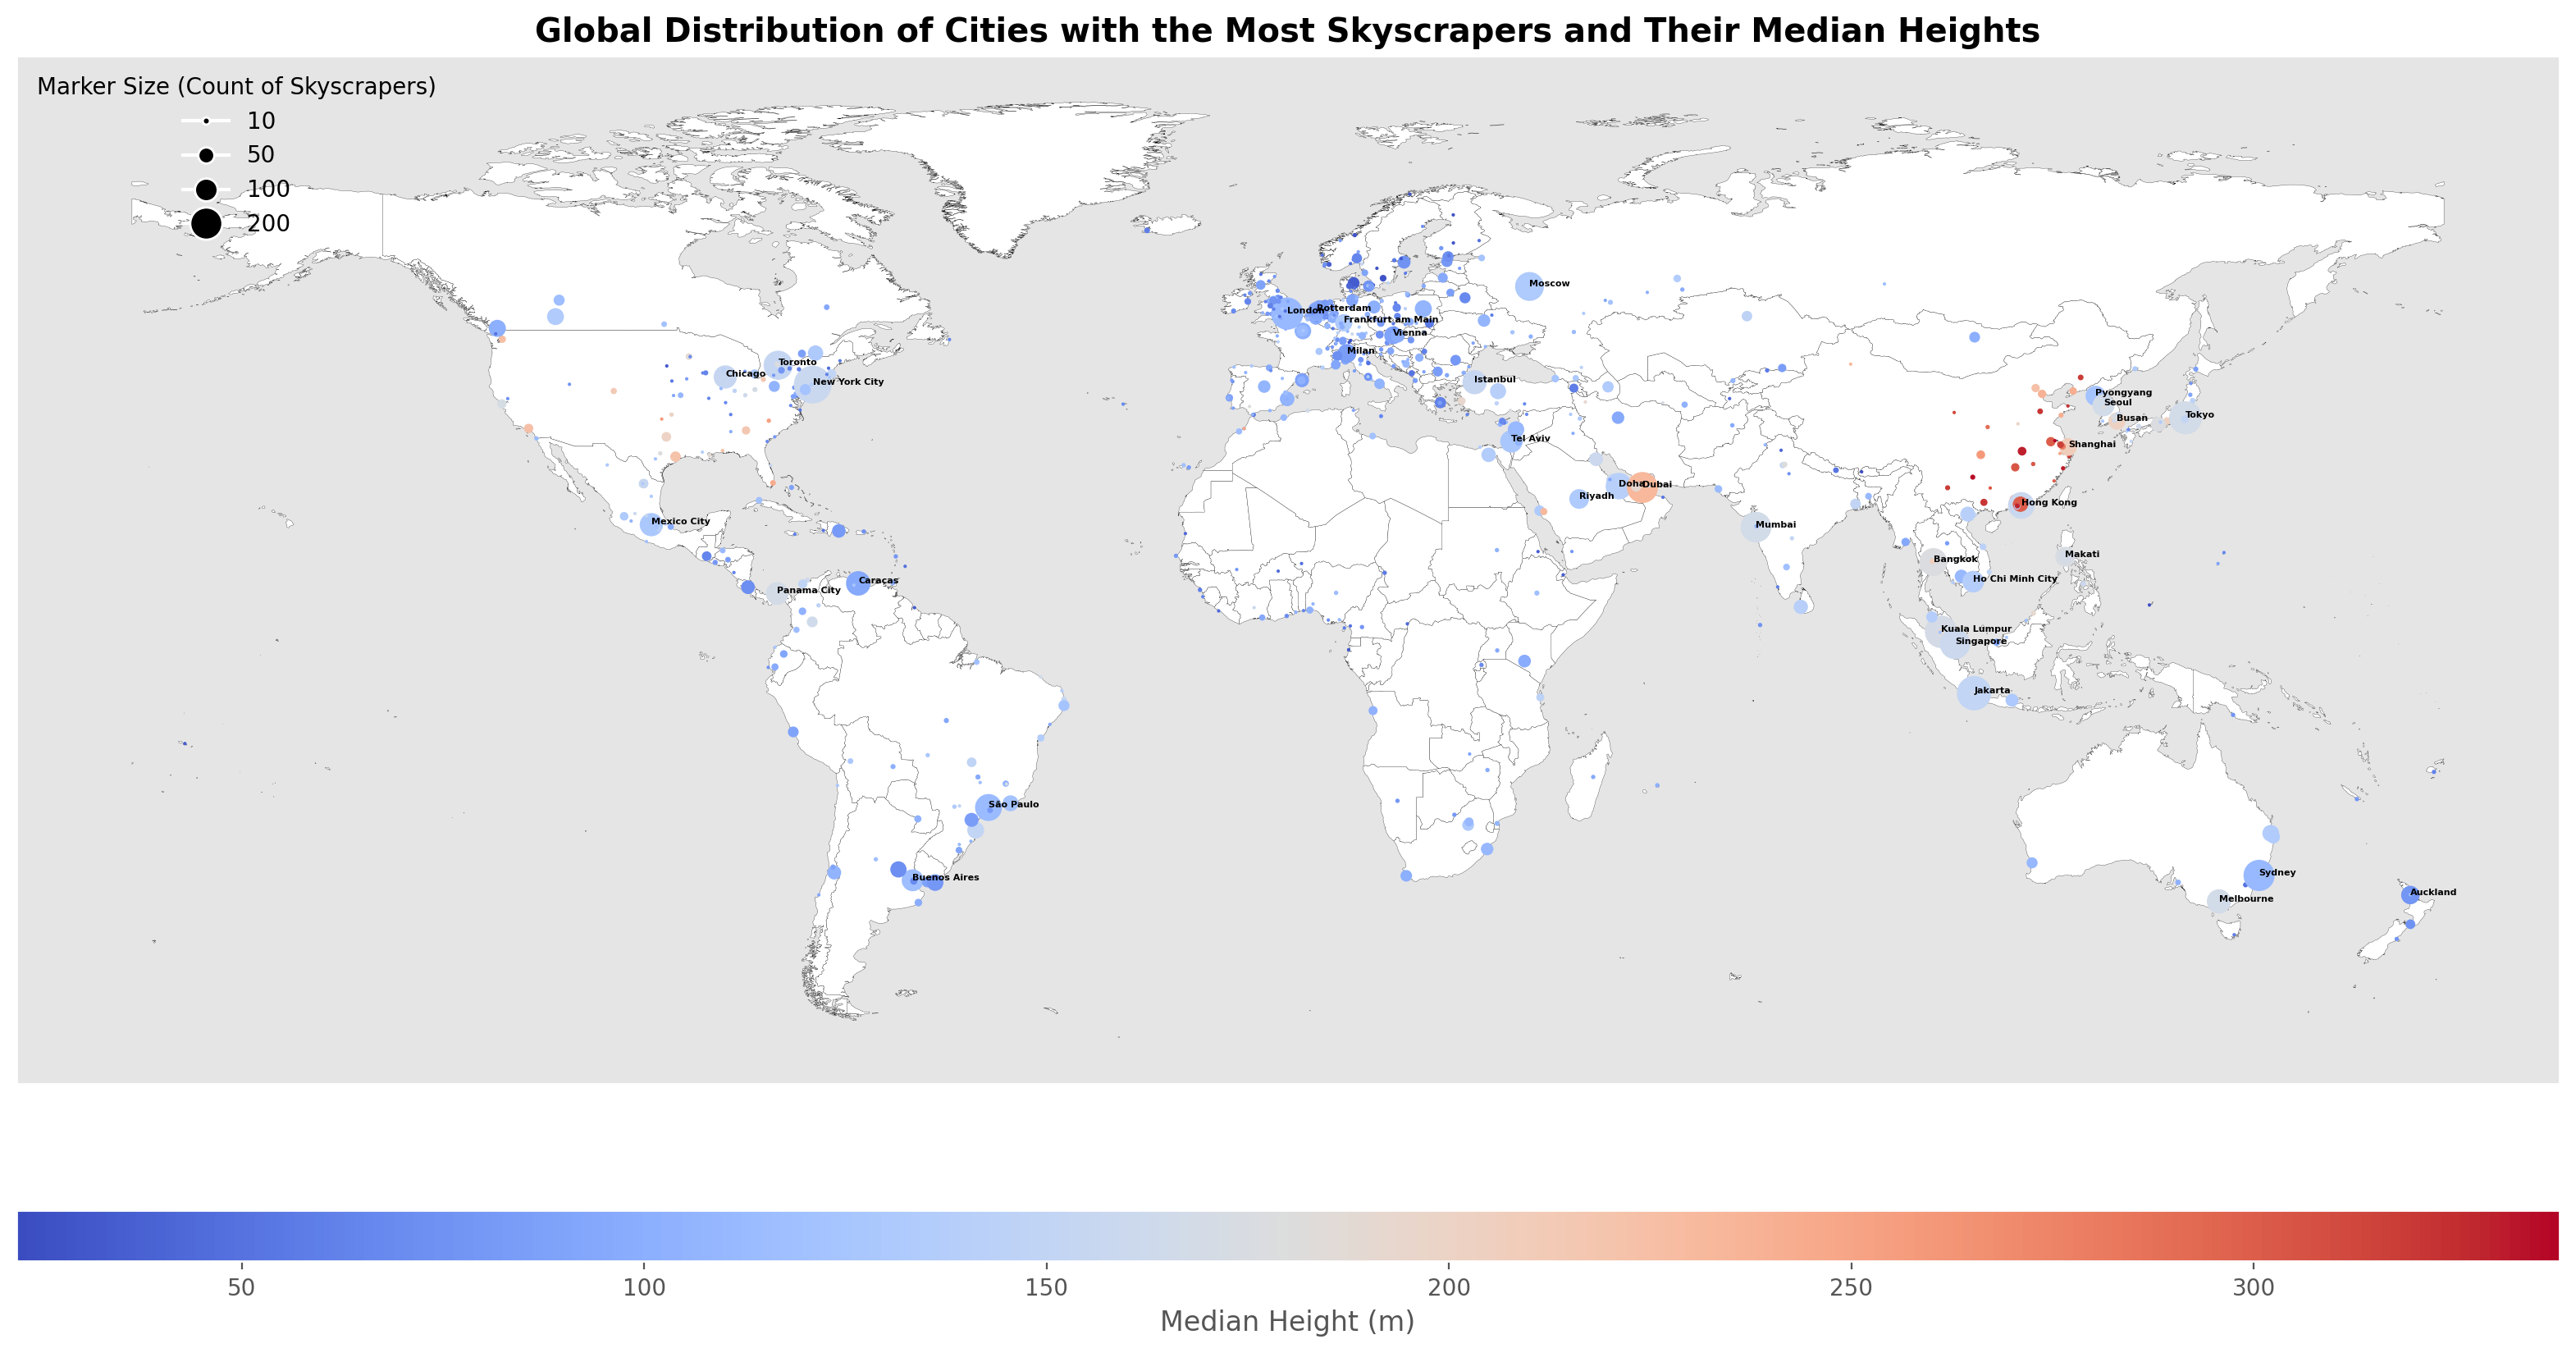

In [ ]:
import geopandas

world=geopandas.read_file(r"C:\Users\berid\python\geopandas\world-administrative-boundaries (detailed)\world-administrative-boundaries.shp")



fig, ax = plt.subplots(figsize=(20, 20),dpi=200)

world.plot(ax=ax, color='white', ec='black', lw=0.1)

grouped = df.groupby(['Country', 'City', 'City Lon', 'City Lat'])['Height (m)'].agg(['median', 'count']).reset_index()

sc = ax.scatter(grouped['City Lon'], grouped['City Lat'], s=grouped['count'], 
                c=grouped['median'], cmap='coolwarm')

cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label('Median Height (m)')

sizes = [10,50,100,200]
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=size**0.5, label=f'{size}') for size in sizes]
ax.legend(handles=handles, title="Marker Size (Count of Skyscrapers)",loc='upper left', frameon=False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Global Distribution of Cities with the Most Skyscrapers and Their Median Heights',fontweight='bold')

for i in range(len(grouped)):
    if grouped['count'].iloc[i]>=50:
        ax.text(grouped['City Lon'].iloc[i],grouped['City Lat'].iloc[i],grouped['City'].iloc[i],size=4,fontweight='bold')


plt.show()


<Axes: title={'center': 'Number of Skyscrapers Built by Year'}, xlabel='Completion Year'>

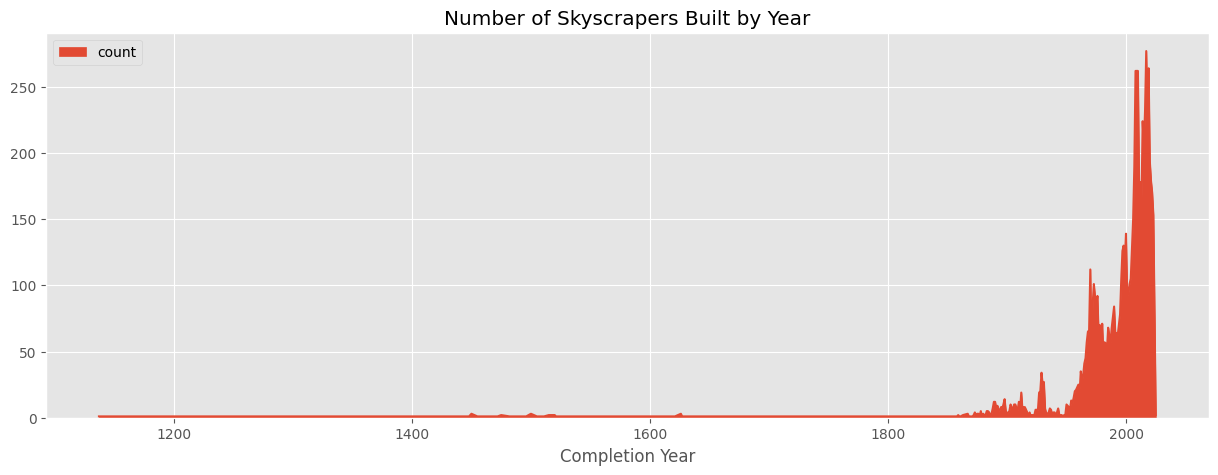

In [85]:

df.groupby('Completion Year')['Height (m)'].agg(['median','count']).reset_index().plot.area(x='Completion Year',y='count',title='Number of Skyscrapers Built by Year',figsize=(15,5))